In [1]:
!pip uninstall numpy -y
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)


In [2]:
import pandas as pd
from huggingface_hub import list_datasets
from datasets import load_dataset
import torch
from transformers import  AutoModel
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


/opt/anaconda3/envs/yt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = load_dataset("dair-ai/emotion", "split")

In [4]:
print(ds["train"][0])  # view first sample
print(ds["train"].column_names)


{'text': 'i didnt feel humiliated', 'label': 0}
['text', 'label']


In [5]:
ds.set_format(type='pandas')

In [6]:
df = ds["train"][:]

In [7]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
df['label'].unique()

array([0, 3, 2, 5, 4, 1])

In [9]:
classes = ds['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [10]:
df['label_name'] = df['label'].apply(lambda x: classes[x])

In [11]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


<Axes: ylabel='label_name'>

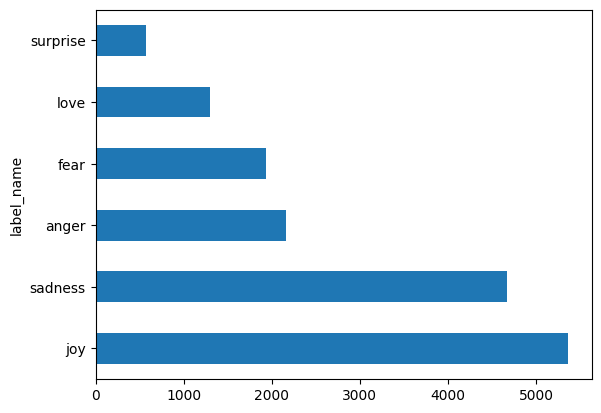

In [12]:
label_counts = df['label_name'].value_counts()
label_counts.plot.barh()

In [13]:
df['words_len'] = df['text'].str.split().apply(len)

<Axes: title={'center': 'words_len'}, xlabel='label_name'>

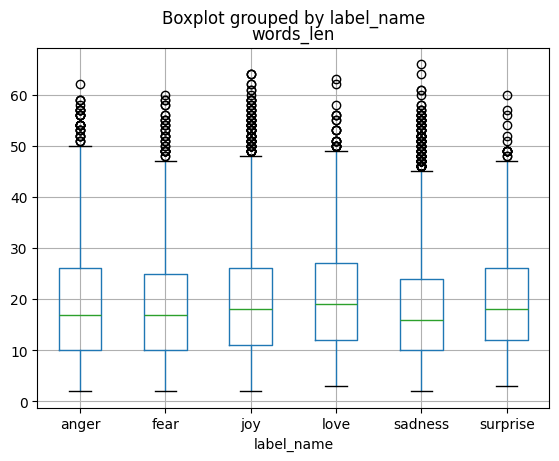

In [14]:
df.boxplot('words_len', by ='label_name')

In [15]:
from transformers import AutoTokenizer

In [16]:
model_ckpt = "distilbert/distilbert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [17]:
text = "i love machine learning"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [18]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens, encoded_text

(['[CLS]', 'i', 'love', 'machine', 'learning', '[SEP]'],
 {'input_ids': [101, 1045, 2293, 3698, 4083, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]})

In [19]:
tokenizer.model_max_length

512

In [20]:
ds.reset_format()

In [21]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True)
    return temp
print(tokenize(ds['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [22]:
emotions_encoded = ds.map(tokenize, batched=True, batch_size=None)
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [23]:
inputs = tokenizer(text, return_tensors='pt')
inputs

{'input_ids': tensor([[ 101, 1045, 2293, 3698, 4083,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [24]:
model = AutoModel.from_pretrained("distilbert-base-uncased")

In [25]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [26]:
with torch.no_grad():
    outputs = model(**inputs)
    
last_hidden_states = outputs.last_hidden_state

In [27]:
outputs, last_hidden_states.shape, text

(BaseModelOutput(last_hidden_state=tensor([[[-0.0916,  0.0262, -0.1532,  ..., -0.0312,  0.2833,  0.3923],
          [ 0.5466,  0.1918, -0.3100,  ...,  0.0519,  0.5837,  0.4638],
          [ 0.9463,  0.6550,  0.5283,  ..., -0.0975,  0.4380,  0.2306],
          [ 0.0219,  0.0201,  0.0326,  ..., -0.3463,  0.0479,  0.2026],
          [-0.4756, -0.2243, -0.5658,  ..., -0.0988,  0.0073,  0.0864],
          [ 0.9618,  0.2298, -0.4998,  ...,  0.2076, -0.6327, -0.1326]]]), hidden_states=None, attentions=None),
 torch.Size([1, 6, 768]),
 'i love machine learning')

In [28]:
num_labels = len(classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
device

device(type='cpu')

In [30]:
batch_size = 64
model_name = 'distilbert-finetuned-toxic'


training_args = TrainingArguments(output_dir=model_name, 
                                  num_train_epochs=2, 
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy='epoch',
                                  disable_tqdm=False)

In [35]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [36]:
from transformers import Trainer

In [37]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)

/var/folders/bg/s92k1gb90vq8f82_y8j2m2380000gn/T/ipykernel_30246/572547672.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.191812,0.922000,0.922570
2,0.168900,0.154028,0.935000,0.935288


TrainOutput(global_step=500, training_loss=0.16891661071777345, metrics={'train_runtime': 2048.4251, 'train_samples_per_second': 15.622, 'train_steps_per_second': 0.244, 'total_flos': 720342861696000.0, 'train_loss': 0.16891661071777345, 'epoch': 2.0})

In [39]:
preds_outputs = trainer.predict(emotions_encoded['test'])
preds_outputs.metrics

{'test_loss': 0.16619063913822174,
 'test_accuracy': 0.924,
 'test_f1': 0.9244886761024914,
 'test_runtime': 21.5065,
 'test_samples_per_second': 92.995,
 'test_steps_per_second': 1.488}

In [40]:
y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = emotions_encoded['test'][:]['label']

In [41]:
from sklearn.metrics import classification_report
print(classes)
print(classification_report(y_true, y_preds))

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       581
           1       0.95      0.94      0.95       695
           2       0.80      0.83      0.81       159
           3       0.93      0.94      0.93       275
           4       0.89      0.88      0.88       224
           5       0.72      0.79      0.75        66

    accuracy                           0.92      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.93      0.92      0.92      2000



In [42]:
label_counts

label_name
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [44]:
trainer.save_model(model_name)         
tokenizer.save_pretrained(model_name)



('distilbert-finetuned-toxic/tokenizer_config.json',
 'distilbert-finetuned-toxic/special_tokens_map.json',
 'distilbert-finetuned-toxic/vocab.txt',
 'distilbert-finetuned-toxic/added_tokens.json',
 'distilbert-finetuned-toxic/tokenizer.json')

In [45]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


In [49]:
model_name = "distilbert-finetuned-toxic"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


In [62]:
text = "what a beautiful song"
input_encoded = tokenizer(text, return_tensors='pt').to(device)

with torch.no_grad():
    outputs = model(**input_encoded)

In [63]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.2726,  2.4616, -0.1174, -1.1327, -1.3094, -1.0852]]), hidden_states=None, attentions=None)

In [64]:
logits = outputs.logits
pred = torch.argmax(logits, dim = 1).item()

In [65]:
pred

1

In [66]:
nm = classes[pred]
nm

'joy'